# Local Field Potental (LFP)

<div class="alert alert-block alert-info">


### ABOUT THIS LESSON 
---

Lesson time: 60 m   
Contributors: Davide Spalla


**In this lesson you will learn:**
- What the Local Field Potential is
- How to filter the LFP singals and compute its power spectrum
- How to perform time-frequency analysis to compute how the power content of different frewquencies varies over time



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
sys.path.append('./code/')
import lfp_functions as lf

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})


## Introduction
---
The Local [Field Potential (LFP)](http://www.scholarpedia.org/article/Local_field_potential#:~:text=The%20local%20field%20potential%20) is the name that neuroscientists use to refer to the extracellular electric potential, i.e. the potential in the space around neurons.   

The use of LFP signals to investigate neural activity is common in systems neuroscience, due to the relative ease of recording (a single electrode is sufficient to extract the signal) and the rich variety of oscillatory phenomena it allows to probe.

The LFP results from the activity of the local neural population (in contrast with electrocorticography and electroencefalography, whose signal is the result of the activity of large cortical areas), but it is not directly related to spiking activity: the main contribution to LFP comes from the postsynaptic membrane potentials.

In this lesson we will look at a series of preprocessing and analysis methods used in the analysis of LFP. They all rely on the fact that the LFP is a continuous signal (unlike spiking activity) usually sampled with very high time resolution (unlike calcium signals). This makes it tractable with a large family of signal processing tools.


 


## Fourier analysis and power spectrum
---
Small explanation

### Example: theta rythm in moving rodents
---

In [4]:
with open('data/lfp_data1.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


Text(0, 0.5, 'voltage (mV)')

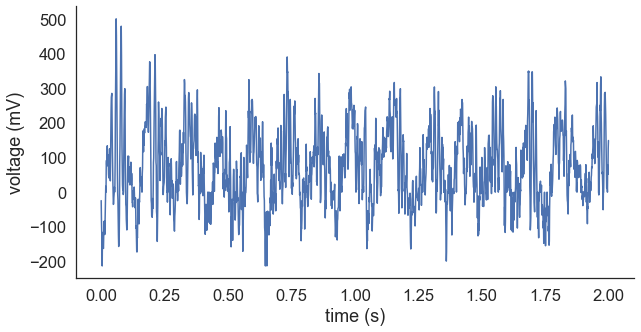

In [5]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,2,2000),lfp[:2000])
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')

There is a lot going on here, but a first thing that meets the eye is a rather prominent oscilaltion at around 8 Hz (8 times per second). Can we see it in the power spectrum? Let's look!

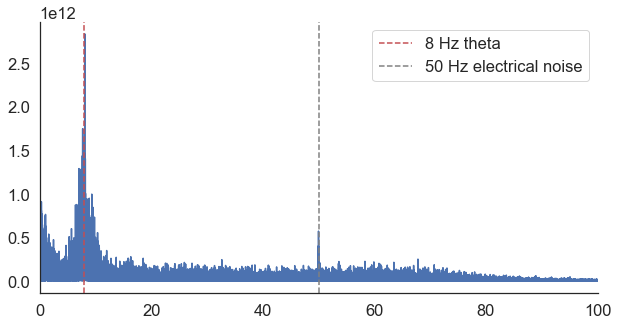

In [6]:
from scipy.fft import fft, fftfreq

n_samples = len(lfp)
sample_dt = 1. / sampling_rate

# we subtract the mean to get rid of the 0 frequency component in the spectrum
centered_lfp = lfp - np.mean(lfp)

transformed_signal = fft(centered_lfp) 

frequencies = fftfreq(n_samples,sample_dt) 

transformed_signal = transformed_signal[:n_samples//2]
frequencies = frequencies[:n_samples//2]

power = abs(transformed_signal)**2

plt.figure(figsize = (10,5))
plt.plot(frequencies,power)
plt.xlim([0,100]) # restrict to 
plt.axvline(x=8 ,c='r',linestyle='--',label='8 Hz theta')
plt.axvline(x=50 ,c='grey',linestyle='--',label='50 Hz electrical noise')

plt.legend()


We can see a clear peak around 8Hz. This is the well studied [theta frequency] band. In rodents, large activity in the theta band is known to be related to active behaviour and locomotion in particular. This makes sense with our data, that where collected from a mouse moving arounf in an arena.

What we can't see here
- This is averaged across the whole session -> No time information

<div class="alert alert-block alert-info">

### Time-frequency tradeoff


## Filtering
---
 A filter is a device that removes unwanted component of a signal. We will look at frequency filters, that get rid of some of the frequencies in the LFP time series.
In the jargon, a *low-pass* filter is a filter getting rid of all the frequencies above a certain threshold frequency, a *high pass* filter eliminates all frequencies below a threshold, and a *band pass* filter, combining the two, will filter the signal in a given frequency band.

In particular, we want to fitler out very low frequency components (as we did when we sbtracted the signal average, which can be interpreted as filtering away the 0 frequency component), and very high frequency, that act as noise for the scale we are interested to investigate.


We won't go into the details of the mathematics of filters here. We will use the scipy implementation of a [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter), a filter that can be expressed as a complex polynomial of a chosen oder, and designed to have a response that is as flat as possible in the pass band, to avoid distorsion of the filtered signal.

<figure> 
<img src="imgs/butterworth_transfer.png" alt="tranfer" width="600" height=400>
<figcaption>
Frequency transfer function of a low-pass butterworth filter with cutoff frequency = 1. Note the log scale on the x axis.
</figcaption>
 </figure>


We will with the `scipy.signal.sosfilt` function, that applies the 'cascaded second order section method', a numerically stable implementation of the standard convolution procedure, that breaks a polynomial filter of high order in sequential application of second order filters.

Text(0, 0.5, 'voltage (mV)')

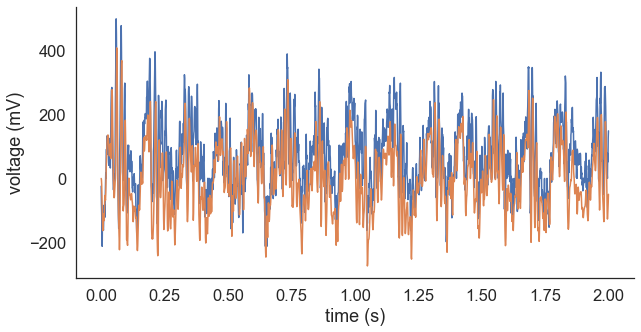

In [14]:
from scipy.signal import butter
from scipy.signal import sosfilt

filter_order = 5 #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability
low_f = 1
high_f = 200

#define filter object
filter = butter(filter_order,[low_f,high_f],
                btype='band', 
                output='sos', 
                fs=sampling_rate)
                
#apply filter to lfp       
wideband_lfp = sosfilt(filter, lfp)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,2,2000),lfp[:2000],label='raw signal')
plt.plot(np.linspace(0,2,2000),wideband_lfp[:2000],label = 'wideband filtered')
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')

Wideband filtering is commonly used to get rid of very low frequency information (such as the average value of the signal, as we did before by centering), and very high components. This allows us to concetrate on the part of the signal that we are interested in (the 1-200 Hz range is a typical one for hippocampal LFP, but this can change for different signals).

We can use filters also to isolate a the particular frequency bands that we are interested in. Below, for example, we can isolate the theta band (8-12 Hz) the slow gamma gamma (20-45 Hz) and the fast gamma (100-140 Hz) components.
We'll use a version of the code above that we wrapped in a `bandpass_filter` function.

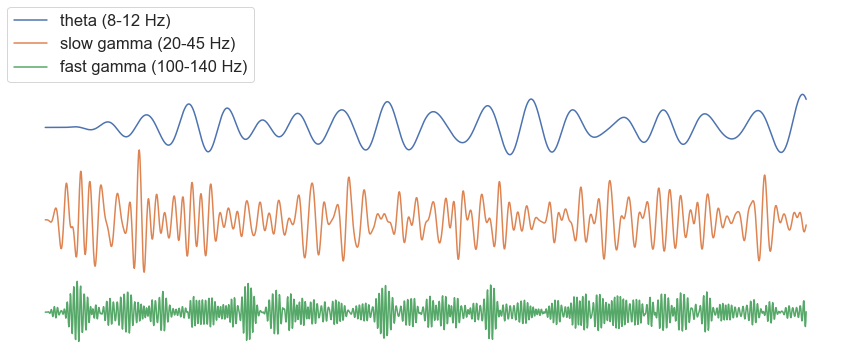

In [15]:
theta_lfp = lf.bandpass_filter(lfp,low_f=8,high_f=12, sampling_rate=sampling_rate)
slow_gamma_lfp = lf.bandpass_filter(lfp,low_f=20,high_f=45, sampling_rate=sampling_rate)
fast_gamma_lfp = lf.bandpass_filter(lfp,low_f=100,high_f=140, sampling_rate=sampling_rate)

plot_offset = 200 #to plot the signal on different lines

plt.figure(figsize=(15,5))
plt.plot(theta_lfp[:2000]+2*plot_offset,label='theta (8-12 Hz)')
plt.plot(slow_gamma_lfp[:2000]+plot_offset,label = 'slow gamma (20-45 Hz)')
plt.plot(fast_gamma_lfp[:2000],label = 'fast gamma (100-140 Hz)')

plt.axis('off')
plt.legend(loc=(0,1))

## Time-frequency analysis
---

In [334]:
from scipy import signal
from pywt import scale2frequency
from pywt import cwt

### Wavelets
A wavelet is a **localized** oscillatory pattern. This means that, unlike the sine or cosine waves that extend indefinitely, the wavelet function $\Psi$ has finite energy:
$$\int_{- \infty}^{+\infty} |\Psi(x)|^{2} dx = E < \infty$$

This is usually achieved by constructing the wavelet function as an oscillatory function multiplied by a (typically exponential) decaying function.  

A popular example is the morlet wavelet, with a cosine wave multiplied by a gaussian window (this is the real morlet wavelet, we will get to know its complex sibling soon).

$$\Psi(x,\omega) = K \cos(\omega x)e^{-x^{2}} $$

The parameter $\omega$ determines the carrier frequencies, i.e. how many oscillations the wavelet is able to make before total dampening.

Once we have our base wavelet, we can construct a whole family of them, by *translating* and *scaling* the bas function:
$$\Psi_{a,b}= K_{a} \Psi(\frac{x-b}{a})$$

This functions will substitute the sines and cosines, and be the basis of the morlet transform.

But first, let's look at the morlet wavelet: in the plot below, we can change the carrier frequency $\omega$ and the scale $a$, to see what effect they have on the function.

In [333]:
from ipywidgets import interact
import ipywidgets as widgets


def plot_wavelet(scale,freq):
    plt.figure(figsize=(10,5))
    wavelet = signal.morlet(1000,s=scale,w=freq)
    envelope = abs(wavelet)
    plt.plot(wavelet.real,label='wavelet (real part)')
    plt.plot(envelope, label = 'envelope')
    plt.legend(loc=[1,1])
    plt.axis('off')

interact(plot_wavelet, scale = widgets.FloatSlider(min=.05, max=2, value=.5),
                       freq = widgets.FloatSlider(min=1, max=20, value=5))

interactive(children=(FloatSlider(value=0.5, description='scale', max=2.0, min=0.05), FloatSlider(value=5.0, d…

<function __main__.plot_wavelet(scale, freq)>

### Wavelet transform
Brief theory explanation

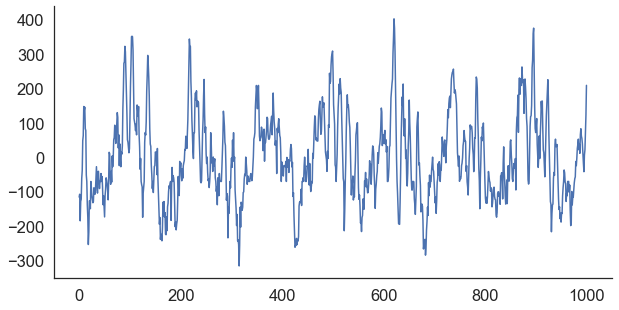

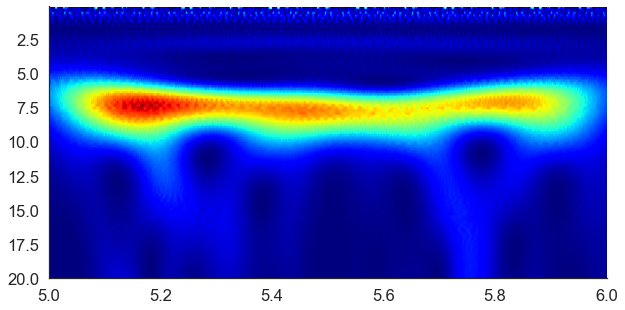

In [5]:
from pywt import scale2frequency
from pywt import cwt

start = 5 #in seconds
end = 6 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

plt.figure(figsize=(10,5))
plt.plot(sig)

#spectrogram with morlet transform

frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = 'cmor1.0-1.0'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto')


Instantanous power in a given frequency band

Text(0, 0.5, 'power (a.u.)')

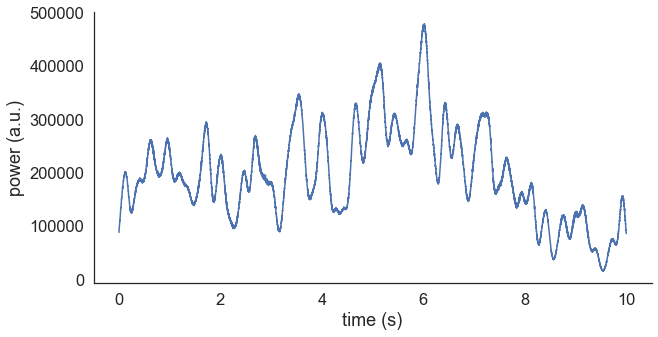

In [6]:
start = 0 #in seconds
end = 10 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

frequencies =  np.linspace(6,10,50)/sampling_rate
wavelet = 'cmor1.0-1.0'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)

power = np.mean(abs(cwtmatr)**2,axis=0)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(power)),power)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')

### Example: theta/delta ratio and REM detection (for exercises)
---


### Example: ripple detection
---


<div class="alert alert-block alert-info">


### Key points 

- The fourier transform of the LFP signal gives information about its frequency content (i.e. which frequencies are have more weights) on average in the given observation window.
- Filtering can be used to isolate and inspect the signal in certain frequency bands, as well as eliminating the high or low frequency component when they get in our way.
- Time-Frequency analysis, with wavelet transforms, can give insights about the local, time-by-time frequency content
- There is a foundamental tradeoff between the time and frequency resolution, due to the uncertainty principle

<div class="alert alert-block alert-info">


### References and resources

**Books & papers**
*  a Scholarpedia aricle of LFP and its interpretation http://www.scholarpedia.org/article/Local_field_potential#:~:text=The%20local%20field%20potential%20

**Websites & blogposts**
* syte one

**Software**
* library 1



## Exercises
You can find the exercises for this lessons in [notebook name](notebook_link)